In [19]:
import pandas as pd #reading dataset
import matplotlib as mpl    #plotting, visualization
import matplotlib.pyplot as plt
import tensorflow as tf #building model
from tensorflow.keras.models import Model
import numpy as np  #playing output with model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import json

import sys
sys.path.append('../../../')   # Add parent directory to Python path
from utils.Plots import *


In [20]:
df = pd.read_csv('../../../data/handlebar/test_data.csv') 
#df.drop('Unnamed: 0', axis=1, inplace=True)
df.shape


(1864, 101)

In [21]:
#scaling data, because neural network works better with scaled data
scaler = StandardScaler()
test_data_scaled = scaler.fit_transform(df.iloc[:, 1:])


In [22]:
# Convert the scaled data back to DataFrames for further processing
test_data_scaled_df = pd.DataFrame(test_data_scaled, columns=df.columns[1:])
test_data_scaled_df['curb_scene'] = df['curb_scene'].values  # Use original DataFrame's curb_scene values
test_data_scaled_df.shape

(1864, 101)

In [23]:
# Filter and slice the data
normal_test_data_scaled = test_data_scaled_df[test_data_scaled_df['curb_scene'] == 0.0].iloc[:, :-1]
abnormal_test_data_scaled = test_data_scaled_df[test_data_scaled_df['curb_scene'] == 1.0].iloc[:, :-1]
normal_test_data_scaled.shape, abnormal_test_data_scaled.shape

((1796, 100), (68, 100))

In [24]:
# Cast to float32
normal_test_data_scaled = normal_test_data_scaled.astype("float32")
abnormal_test_data_scaled = abnormal_test_data_scaled.astype("float32")
normal_test_data_scaled.shape, abnormal_test_data_scaled.shape

((1796, 100), (68, 100))

In [25]:
load_model = tf.keras.models.load_model('../../../models/autoencoder_best.keras')

In [26]:
# Verify the saved data
with open('../../../models/autoencoder_thresholds.json', 'r') as f:
    loaded_thresholds = json.load(f)
print("Saved thresholds:", loaded_thresholds)

Saved thresholds: {'low_threshold': 0.39, 'middle_threshold': 0.81, 'high_threshold': 1.27}


In [27]:
# Get reconstruction errors for test data
reconstructions_normal_test = load_model.predict(normal_test_data_scaled)
reconstructions_abnormal_test = load_model.predict(abnormal_test_data_scaled)
# Calculate MAE losses
test_loss_normal = tf.keras.losses.mae(reconstructions_normal_test, normal_test_data_scaled)
test_loss_abnormal = tf.keras.losses.mae(reconstructions_abnormal_test, abnormal_test_data_scaled)

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [28]:
min_test_loss = min(test_loss_abnormal)
min_test_loss

<tf.Tensor: shape=(), dtype=float32, numpy=0.3907053470611572>

In [35]:
# Function to create and display confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    
    # Add labels with binary classes
    labels = ['0', '1']
    plt.xticks([0, 1], labels)
    plt.yticks([0, 1], labels)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # Add numbers to cells
    thresh = cm.max() / 2.
    for i in range(2):
        for j in range(2):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.show()
    
    # Print classification report with binary labels
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, 
                              target_names=['Normal (0)', 'Abnormal (1)'],
                              digits=3))  # Limit decimal places to 3

In [36]:
# Combine test losses and create true labels
all_test_losses = np.concatenate([test_loss_normal.numpy(), test_loss_abnormal.numpy()])
true_labels = np.concatenate([np.zeros(len(test_loss_normal)), np.ones(len(test_loss_abnormal))])


=== Results for low_threshold (0.3900) ===


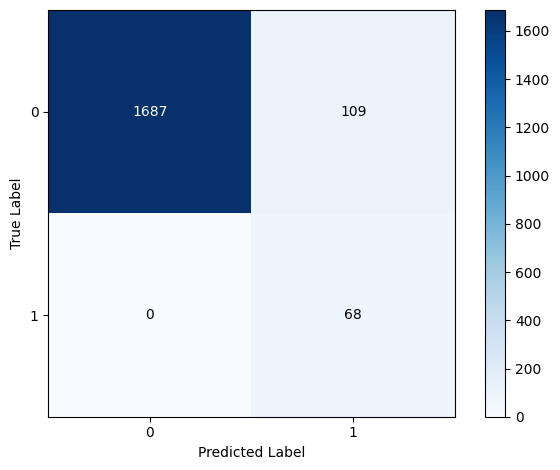


Classification Report:
              precision    recall  f1-score   support

  Normal (0)      1.000     0.939     0.969      1796
Abnormal (1)      0.384     1.000     0.555        68

    accuracy                          0.942      1864
   macro avg      0.692     0.970     0.762      1864
weighted avg      0.978     0.942     0.954      1864


=== Results for middle_threshold (0.8100) ===


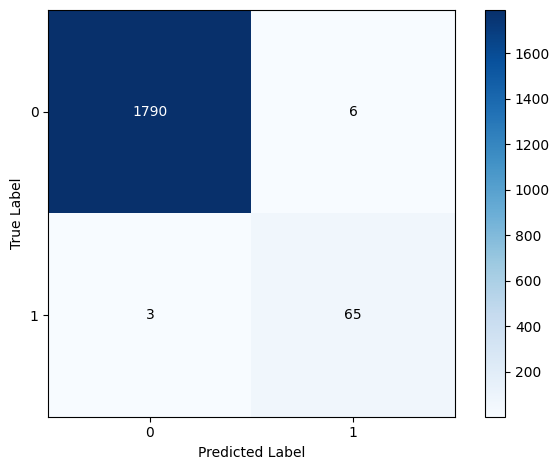


Classification Report:
              precision    recall  f1-score   support

  Normal (0)      0.998     0.997     0.997      1796
Abnormal (1)      0.915     0.956     0.935        68

    accuracy                          0.995      1864
   macro avg      0.957     0.976     0.966      1864
weighted avg      0.995     0.995     0.995      1864


=== Results for high_threshold (1.2700) ===


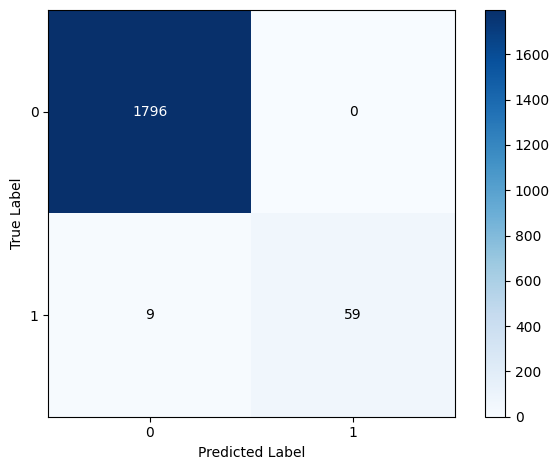


Classification Report:
              precision    recall  f1-score   support

  Normal (0)      0.995     1.000     0.998      1796
Abnormal (1)      1.000     0.868     0.929        68

    accuracy                          0.995      1864
   macro avg      0.998     0.934     0.963      1864
weighted avg      0.995     0.995     0.995      1864



In [37]:
# Make predictions using each threshold
for threshold_name, threshold_value in loaded_thresholds.items():
    print(f"\n=== Results for {threshold_name} ({threshold_value:.4f}) ===")
    predictions = (all_test_losses > threshold_value).astype(int)
    plot_confusion_matrix(true_labels, predictions, f'Confusion Matrix - {threshold_name}')